# Part 4: Naive Bayes Classifier

Naive Bayes Classifier works on the principle of Baye's Theorem. Learn more about it [here](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/) and [here](https://scikit-learn.org/stable/modules/naive_bayes.html) 

It assumes that there is conditional independency in feature vectors.
Naive Bayes Classifier are faster then other sophisticated learning algorithms. 

We will use different Naive Bayes Classifiers based on the distribution of P(x/y).
* Gaussian NB
* Multinomial NB
* Bernoulli NB

Let's dig into this deeper.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
import re

We will import required libraries

In [9]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [10]:
#getting data
computer_subclass=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_subclass=['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']  
comp_train=fetch_20newsgroups(subset='train',categories=computer_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
rec_train=fetch_20newsgroups(subset='train',categories=rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
comp_test=fetch_20newsgroups(subset='test',categories=computer_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
rec_test=fetch_20newsgroups(subset='test',categories=rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_data=comp_train.data+comp_test.data+rec_train.data+rec_test.data
stemmer=SnowballStemmer("english")


**Since SVM is a supervised learning algorithm, we will need labels. So, we will label the data before training the classification model. We will use [+1, -1] classification. '+1' for 'Computer Technology' and '-1' for 'Recreational Activity' classes.**

In [11]:
classification_train=[1]*len(comp_train.data)+[-1]*len(rec_train.data)
classification_test=[1]*len(comp_test.data)+[-1]*len(rec_test.data)

**Preprocessing the data**

We have learnt how to do this before in Part_1 and Part_2

In [12]:
stemmer=SnowballStemmer("english")
#preprocessing data
punctuations='[! \" # $ % \& \' \( \) \ * + , \- \. \/ : ; <=> ? @ \[ \\ \] ^ _ ` { \| } ~]'
def preprocessing(data_list):
    for i in range(len(data_list)):
        data_list[i]=" ".join([stemmer.stem(data) for data in re.split(punctuations,data_list[i])])
        data_list[i]=data_list[i].replace('\n','').replace('\t','').replace('\r','')
preprocessing(all_data)

**We will now tokenize the documents and create a TFIDF matrix, which will be sparse. We will also reduce the dimensions of the features to 50 using LSI and NMF**

min_df = 2

In [14]:
count_vect=CountVectorizer(min_df=2,stop_words ='english')
X_counts=count_vect.fit_transform(all_data)

#Feature extraction using TFxIDF
tfidf_transformer=TfidfTransformer()
X_tfidf=tfidf_transformer.fit_transform(X_counts)

#Dimensionality reduction using LSI
svd=TruncatedSVD(n_components=50,n_iter=10,random_state=42)
svd.fit(X_tfidf)
LSI_SVD=svd.transform(X_tfidf)

#Dimensionality reduction using NMF
from sklearn.decomposition import NMF
model=NMF(n_components=50,init='random',random_state=0)
LSI_NMF=model.fit_transform(X_tfidf)
# print(LSI.shape)

### Gaussian NB with SVD

In [16]:
#Split train and testing datasts
split_point_1=len(comp_train.data)
split_point_2=split_point_1+len(comp_test.data)
split_point_3=split_point_2+len(rec_train.data)

LSI_test_SVD=np.concatenate((LSI_SVD[split_point_1 : split_point_2],LSI_SVD[split_point_3:]))
LSI_train_SVD=np.concatenate((LSI_SVD[0:split_point_1],LSI_SVD[split_point_2:split_point_3]))

We will use SVD for dimensionality reduction. 

We will first create an instance of Gaussian NB classifier

In [17]:
classifier_GNB = GaussianNB()

We will fit LSI_train_SVD with labelled data of classification_train_SVD.

In [21]:
classifier_GNB.fit(LSI_train_SVD, classification_train)

GaussianNB(priors=None, var_smoothing=1e-09)

We will now predict on LSI_test_SVD

In [24]:
predicted_class_GNB=classifier_GNB.predict(LSI_test_SVD)

In [76]:
actual_class_GNB = classification_test

In [77]:
LSI_test_SVD[:]

array([[ 0.08739473,  0.04804312,  0.00472738, ..., -0.02296238,
         0.02806086, -0.02319277],
       [ 0.17148571, -0.09897292, -0.10019029, ..., -0.0270495 ,
        -0.01530216,  0.00229864],
       [ 0.14821389, -0.08731035,  0.03623614, ...,  0.00180823,
        -0.03037294,  0.05326388],
       ...,
       [ 0.10856059,  0.07225104, -0.01058911, ..., -0.00058122,
        -0.00385698,  0.0249344 ],
       [ 0.05552726,  0.04876174, -0.01475507, ..., -0.01172822,
        -0.00411069,  0.00243525],
       [ 0.10678282,  0.23485621, -0.07916782, ...,  0.02035546,
        -0.01292932,  0.02513128]])

We will predict the probability

In [38]:
predict_probability_GNB=classifier_GNB.predict_proba(LSI_test_SVD[:])[:,1]
predict_probability_GNB

array([2.21703468e-02, 1.00000000e+00, 9.99995301e-01, ...,
       5.79113742e-08, 3.03427966e-08, 6.00526586e-06])

Classification Report

In [78]:
print('Classification report:')
print(metrics.classification_report(actual_class_GNB,predicted_class_GNB,target_names=["Com Tech","Rec Act"]),)

Classification report:
              precision    recall  f1-score   support

    Com Tech       0.75      0.90      0.82      1590
     Rec Act       0.88      0.70      0.78      1560

   micro avg       0.80      0.80      0.80      3150
   macro avg       0.82      0.80      0.80      3150
weighted avg       0.82      0.80      0.80      3150



Confusion Matrix

In [79]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_GNB,predicted_class_GNB))

Confusion Matrix:
[[1437  153]
 [ 467 1093]]


In [80]:
print('Total accuracy: ')
print(np.mean(actual_class_GNB==predicted_class_GNB))


Total accuracy: 
0.8031746031746032


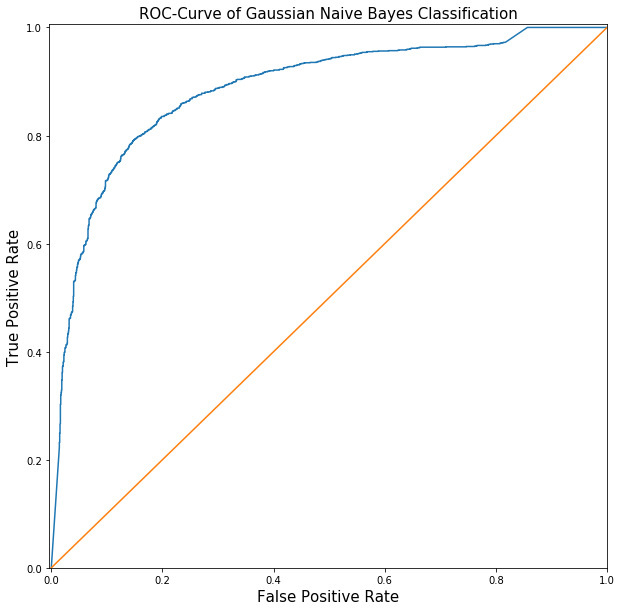

In [81]:
fpr,tpr,threshold=roc_curve(actual_class_GNB,predict_probability_GNB)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Gaussian Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

## Multinomial NB

In [82]:
all_train=fetch_20newsgroups(subset='train',categories=computer_subclass+rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_test=fetch_20newsgroups(subset='test',categories=computer_subclass+rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_data=all_train.data+all_test.data

In [83]:
preprocessing(all_train.data)
preprocessing(all_test.data)

Creating TFIDF matrix

In [86]:
count_vect=CountVectorizer(min_df=2,stop_words ='english')
X_counts_MNNB=count_vect.fit_transform(all_train.data)

#Feature extraction using TFxIDF
tfidf_transformer=TfidfTransformer()
X_tfidf_MNNB=tfidf_transformer.fit_transform(X_counts_MNNB)

all_train.target

array([6, 7, 4, ..., 6, 6, 2], dtype=int64)

In [87]:
all_test.target

array([3, 2, 3, ..., 7, 1, 1], dtype=int64)

Create instance of Multinomial NB

In [88]:
clf=MultinomialNB()
clf.fit(X_tfidf_MNNB,all_train.target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [89]:
X_new_counts = count_vect.transform(all_test.data)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted_class_MNNB = clf.predict(X_new_tfidf)
actual_class_MNNB = all_test.target
predicted_class_MNNB

array([3, 2, 0, ..., 4, 1, 1], dtype=int64)

In [90]:
print('Classification report:')
print(metrics.classification_report(actual_class_MNNB,predicted_class_MNNB,
                                    target_names=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',
                                                                              'rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']),)

Classification report:
                          precision    recall  f1-score   support

           comp.graphics       0.77      0.79      0.78       389
 comp.os.ms-windows.misc       0.74      0.62      0.68       394
comp.sys.ibm.pc.hardware       0.66      0.76      0.71       392
   comp.sys.mac.hardware       0.80      0.69      0.74       385
               rec.autos       0.83      0.83      0.83       396
         rec.motorcycles       0.88      0.81      0.84       398
      rec.sport.baseball       0.93      0.83      0.88       397
        rec.sport.hockey       0.72      0.94      0.81       399

               micro avg       0.79      0.79      0.79      3150
               macro avg       0.79      0.78      0.78      3150
            weighted avg       0.79      0.79      0.78      3150



In [91]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_MNNB,predicted_class_MNNB))



Confusion Matrix:
[[307  24  21  16   8   5   1   7]
 [ 46 246  59  12   6   8   1  16]
 [ 13  38 297  31   3   1   0   9]
 [ 15  19  53 267   9   4   1  17]
 [  2   2   2   2 328  19   8  33]
 [  6   0   6   5  31 323   6  21]
 [  9   2   6   0   3   3 331  43]
 [  3   1   3   1   6   4   7 374]]


In [92]:
print('Total accuracy: ')
print(np.mean(actual_class==predicted_class))

Total accuracy: 
0.785079365079365


## Bernouilli NB

In [93]:
classifier_BNB = BernoulliNB()

We will fit LSI_train_SVD with labelled data of classification_train_SVD.

In [95]:
classifier_BNB.fit(LSI_train_SVD, classification_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

We will now predict on LSI_test_SVD

In [97]:
predicted_class_BNB=classifier_BNB.predict(LSI_test_SVD)
actual_class_BNB = classification_test

In [98]:
predict_probability_BNB=classifier_BNB.predict_proba(LSI_test_SVD[:])[:,1]
predict_probability_BNB

array([0.09255328, 0.93471593, 0.7692961 , ..., 0.19175852, 0.22421953,
       0.23004187])

In [99]:
print('Classification report:')
print(metrics.classification_report(actual_class_BNB,predicted_class_BNB,target_names=["Com Tech","Rec Act"]),)

Classification report:
              precision    recall  f1-score   support

    Com Tech       0.86      0.89      0.88      1590
     Rec Act       0.89      0.85      0.87      1560

   micro avg       0.87      0.87      0.87      3150
   macro avg       0.87      0.87      0.87      3150
weighted avg       0.87      0.87      0.87      3150



In [100]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_BNB,predicted_class_BNB))

Confusion Matrix:
[[1417  173]
 [ 227 1333]]


In [101]:
print('Total accuracy: ')
print(np.mean(actual_class_BNB==predicted_class_BNB))


Total accuracy: 
0.873015873015873


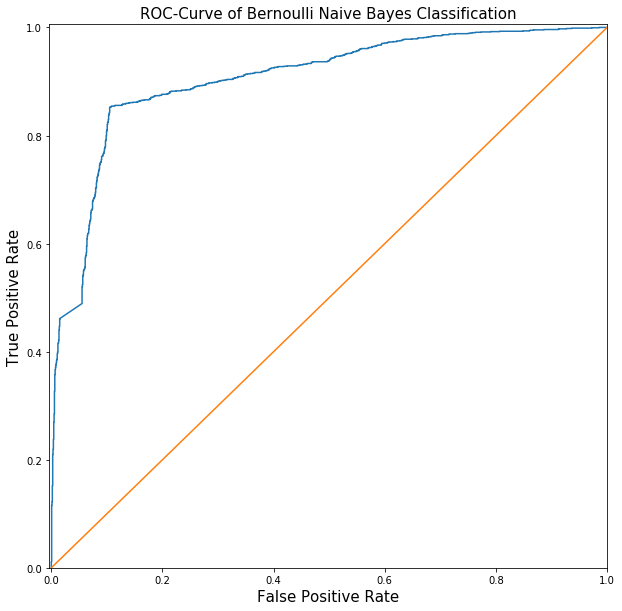

In [102]:
fpr,tpr,threshold=roc_curve(actual_class_BNB,predict_probability_BNB)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Bernoulli Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()